In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat


def _to_str_list(mat_field):
    """
    Convert MATLAB cell/char arrays to a flat Python list of strings.
    Handles cases like: cell array of strings, char matrix, or object arrays.
    """
    x = np.squeeze(mat_field)
    if x.dtype.kind in ("U", "S"):  # already a (numpy) string array
        # char matrix (n x m) -> single string, else array of strings
        if x.ndim == 1:
            return [str(s) for s in x.tolist()]
        else:
            return ["".join(row).strip() for row in x.tolist()]
    # likely an object array (cell array)
    out = []
    for elem in np.ravel(x):
        s = elem
        # char arrays come as ndim>=2 with dtype 'U'/'S'
        if isinstance(elem, np.ndarray) and elem.dtype.kind in ("U", "S"):
            s = "".join(np.atleast_1d(elem).tolist()).strip()
        elif isinstance(elem, np.ndarray) and elem.dtype.kind in ("i", "f"):
            s = str(elem.item()) if elem.size == 1 else "".join(map(str, elem.tolist()))
        else:
            s = str(elem)
        out.append(s)
    return out

In [4]:
import math
math.factorial(26)/(math.factorial(26-5)*math.factorial(5))

65780.0

In [ ]:
directory = "/mnt/hcleroy/PostDoc2/octopus_smelling/experimental_data"
mat_path = directory+"/20251017_HiPlexResults.mat"
# --- Load .mat ---
md = loadmat(mat_path, squeeze_me=True, struct_as_record=False)
if "binaryTable_Stack" not in md or "CRnames" not in md:
    raise KeyError("Expected fields 'binaryTable_Stack' and 'CRnames' in the .mat file.")

A = np.array(md["binaryTable_Stack"]).astype(bool).astype(int)  # shape: (n_receptors, n_cells)
CRnames = _to_str_list(md["CRnames"])
nR, nC = A.shape


In [3]:
CRnames

['CR518',
 'CR888',
 'CR840',
 'CR829',
 'CR986',
 'CR918',
 'CR990',
 'CR989',
 'CR522',
 'CR992',
 'CR737',
 'CR212',
 'CR041',
 'CR999',
 'CR111',
 'CR628',
 'CR289',
 'CR244',
 'CR490',
 'CR370',
 'CR776',
 'CR560',
 'CR988',
 'CR836']

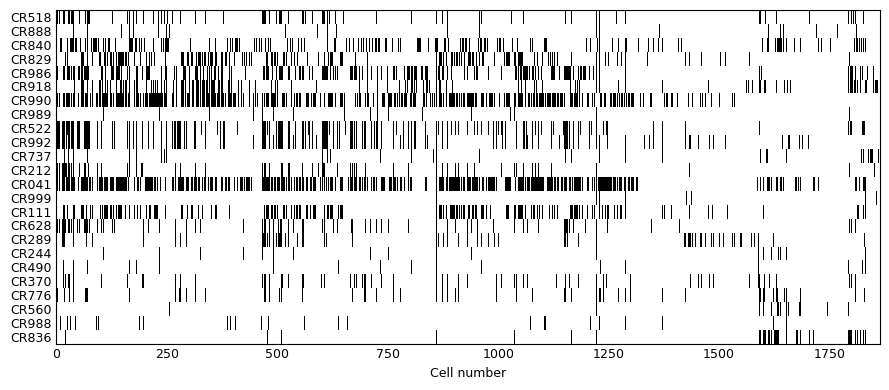

In [3]:

# ===============================
# RASTER PLOT WITH ALL CELLS
# ===============================
plt.figure(figsize=(9, 4))  # ~900x400 px
plt.imshow(A, aspect="auto", cmap="gray_r", interpolation="nearest")
plt.xlabel("Cell number", fontsize=9)
plt.yticks(np.arange(nR), CRnames)
ax = plt.gca()
ax.tick_params(length=0, labelsize=9)
plt.tight_layout()

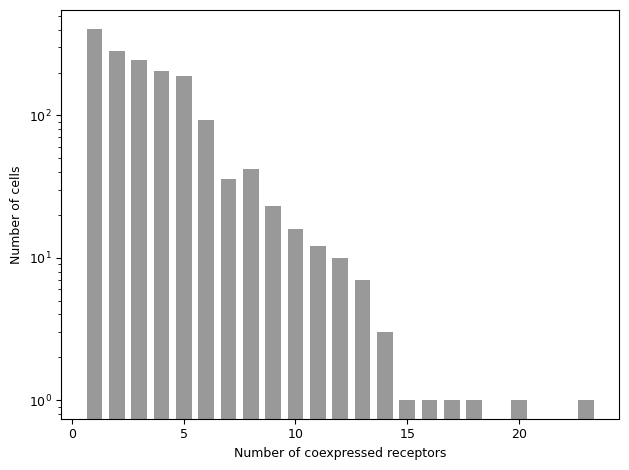

In [4]:
# =========================================
# HISTOGRAM: NUMBER OF COEXPRESSED SUBUNITS
# =========================================
coexp = A.sum(axis=0)  # per cell
coexp_nz = coexp[coexp != 0]
# integer bins: use bincount for exact integer histogram
if coexp_nz.size > 0:
    max_k = int(coexp_nz.max())
    counts = np.bincount(coexp_nz, minlength=max_k + 1)[1:]  # skip zero bin
    centers = np.arange(1, max_k + 1)
else:
    counts = np.array([])
    centers = np.array([])

plt.figure()
plt.bar(centers, counts, width=0.7, color=[0.6, 0.6, 0.6])
plt.ylabel("Number of cells", fontsize=9)
plt.xlabel("Number of coexpressed receptors", fontsize=9)
plt.gca().tick_params(labelsize=9)
plt.tight_layout()
plt.yscale('log')

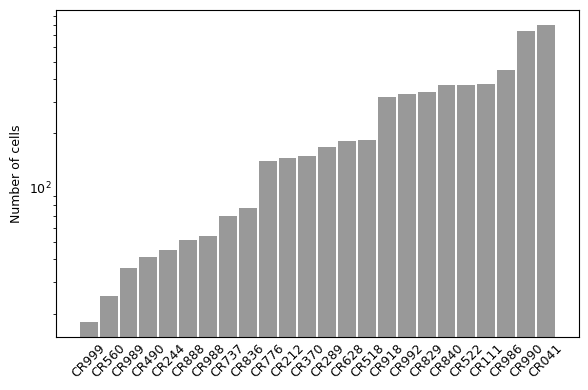

In [23]:
# ================================================
# RELATIVE ABUNDANCE OF EACH RECEPTOR IN POPULATION
# ================================================
CR_counts = A.sum(axis=1)  # per receptor
plt.figure(figsize=(6, 4.))  # ~500x250 px
plt.bar(np.arange(1, nR + 1), CR_counts[np.argsort(CR_counts)], width=0.9, color=[0.6, 0.6, 0.6])
plt.ylabel("Number of cells", fontsize=9)
plt.xticks(np.arange(1, nR + 1), np.array(CRnames)[np.argsort(CR_counts)], rotation=45)
ax = plt.gca()
ax.tick_params(length=0, labelsize=9)
plt.tight_layout()
plt.yscale('log')

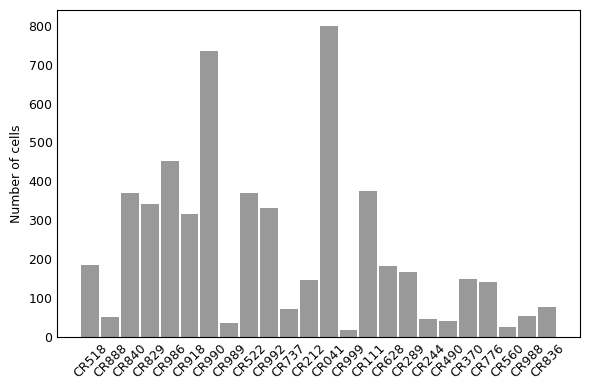

In [22]:
# ================================================
# RELATIVE ABUNDANCE OF EACH RECEPTOR IN POPULATION
# ================================================
CR_counts = A.sum(axis=1)  # per receptor
plt.figure(figsize=(6, 4))  # ~500x250 px
plt.bar(np.arange(1, nR + 1), CR_counts, width=0.9, color=[0.6, 0.6, 0.6])
plt.ylabel("Number of cells", fontsize=9)
plt.xticks(np.arange(1, nR + 1), CRnames, rotation=45)
ax = plt.gca()
ax.tick_params(length=0, labelsize=9)
plt.tight_layout()


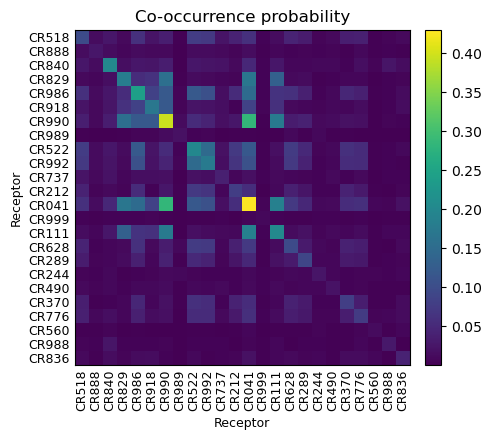

In [27]:
# ==================
# PAIRS LIKELIHOODS
# ==================
# Co-occurrence counts and probability (receptor x receptor)
pairComparison = A @ A.T  # (nR x nR)
pairProb = pairComparison / float(nC)

plt.figure(figsize=(5, 4.5))
im = plt.imshow(pairProb, aspect="equal", cmap="viridis", interpolation="nearest")
plt.title("Co-occurrence probability", fontsize=12)
plt.xlabel("Receptor", fontsize=9)
plt.ylabel("Receptor", fontsize=9)
plt.xticks(np.arange(nR), CRnames, rotation=90)
plt.yticks(np.arange(nR), CRnames)
plt.gca().tick_params(length=0, labelsize=9)
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)  # Adjust fraction and pad as needed
plt.tight_layout()

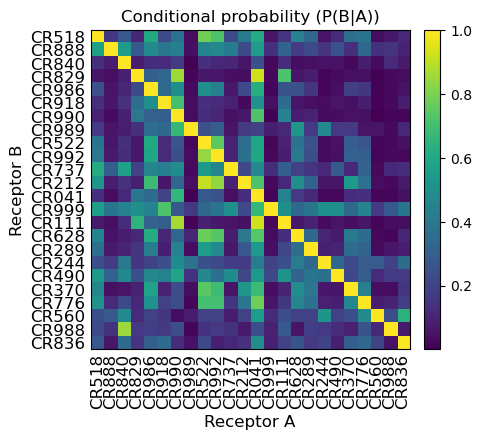

In [28]:
# Conditional probability: MATLAB code computes P(B|A) = pairComparison[i,j]/numCells_perCR[i]
numCells_perCR = np.diag(pairComparison).astype(float)  # size (nR,)
with np.errstate(invalid="ignore", divide="ignore"):
    condProb = pairComparison / numCells_perCR[:, None]  # broadcast over columns
condProb = np.where(np.isfinite(condProb), condProb, np.nan)

plt.figure(figsize=(5, 4.5))
im = plt.imshow(condProb, aspect="equal", cmap="viridis", interpolation="nearest")
plt.title("Conditional probability (P(B|A))", fontsize=12)
plt.xlabel("Receptor A", fontsize=12)
plt.ylabel("Receptor B", fontsize=12)
plt.xticks(np.arange(nR), CRnames, rotation=90)
plt.yticks(np.arange(nR), CRnames)
plt.gca().tick_params(length=0, labelsize=12)
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)  # Adjust fraction and pad as needed
plt.tight_layout()

In [30]:

# ===========================
# NUMBER OF UNIQUE COMBINATIONS
# ===========================
M_cells = A.T  # shape ~ (n_cells x n_receptors)
# 'stable' unique rows: use return_index to preserve first occurrence order
uniq_rows, idx_first, inv_idx = np.unique(M_cells, axis=0, return_index=True, return_inverse=True)
# sort unique rows by first occurrence (stable)
order_stable = np.argsort(idx_first)
uniquePatterns = uniq_rows[order_stable]
# counts per pattern (based on inverse index)
counts = np.bincount(inv_idx)
# reorder counts to match uniquePatterns order
counts = counts[np.argsort(idx_first)]

uniqueReceptors = uniquePatterns.shape[0]
print(f"Number of unique expression patterns: {uniqueReceptors}")

Number of unique expression patterns: 477


In [31]:
# Most common patterns
order_counts = np.argsort(counts)[::-1]
topPatt = min(100, uniqueReceptors)
print("Top patterns:")
print(counts[order_counts][:topPatt])

for nPatt in range(topPatt):
    patternIdx = order_counts[nPatt]
    genesOn_mask = uniquePatterns[patternIdx].astype(bool)
    genesOn = [CRnames[i] for i, on in enumerate(genesOn_mask) if on]
    print(f"\nPattern {nPatt+1} (appears {counts[patternIdx]} times):")
    print(genesOn)

Top patterns:
[289 190  91  77  52  48  39  31  31  25  24  22  22  21  21  21  18  17
  16  15  15  15  14  13  13  13  11  10   9   9   9   9   9   9   8   7
   7   7   6   6   6   5   5   5   4   4   4   4   4   4   4   4   4   4
   4   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3
   3   3   3   3   3   3   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2]

Pattern 1 (appears 289 times):
[]

Pattern 2 (appears 190 times):
['CR840']

Pattern 3 (appears 91 times):
['CR829', 'CR990', 'CR041', 'CR111']

Pattern 4 (appears 77 times):
['CR990', 'CR041']

Pattern 5 (appears 52 times):
['CR990']

Pattern 6 (appears 48 times):
['CR990', 'CR041', 'CR111']

Pattern 7 (appears 39 times):
['CR829', 'CR918', 'CR990', 'CR041', 'CR111']

Pattern 8 (appears 31 times):
['CR829', 'CR986', 'CR990', 'CR041', 'CR111']

Pattern 9 (appears 31 times):
['CR986', 'CR918', 'CR990']

Pattern 10 (appears 25 times):
['CR041']

Pattern 11 (appears 24 times

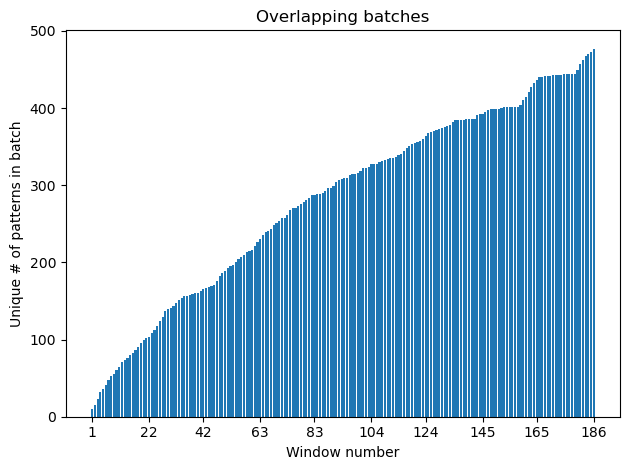

In [ ]:
# ===========================
# BATCH ANALYSIS - MOVING WINDOWS (cumulative windows like MATLAB)
# ===========================
nCells = M_cells.shape[0]
batchEdge = np.arange(10, nCells + 1, 10)  # 10:10:nCells
nBatches = len(batchEdge)
uniquePerBatch = np.zeros(nBatches, dtype=int)
startIdx = 0  # Python 0-based

for b, edge in enumerate(batchEdge):
    stopIdx = min(startIdx + edge, nCells)  # cumulative from start
    if startIdx >= nCells:
        break
    sub = M_cells[startIdx:stopIdx, :]
    # unique rows count
    uniquePerBatch[b] = np.unique(sub, axis=0).shape[0]

plt.figure()
plt.bar(np.arange(1, nBatches + 1), uniquePerBatch)
plt.xlabel("Window number")
plt.ylabel("Unique # of patterns in batch")
plt.title("Overlapping batches")
    
# thinner x-tick labels
numLabels = min(10, nBatches)
idxLabels = np.unique(np.round(np.linspace(1, nBatches, numLabels)).astype(int))
plt.xticks(idxLabels, [str(i) for i in idxLabels])
plt.tight_layout()

plt.show()